<a href="https://colab.research.google.com/github/billamiable/awesome-SLAM-list/blob/master/train_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        # TO-DO: super?
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # when this will downsample
        if self.downsample is not None:
            # Projection Shortcut for matching the output size
            # input through network is half, so x should be half
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, stride = 2,num_classes=1000, zero_init_residual=False, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        print('stride=', stride)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=stride, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=stride, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            # Projection Shortcut
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))
        # constructs the Sequential Model that comprises the information 
        # passed on those arguments
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # it is correct
        # cifar 32*32
        # 7*7, 64, stride 2
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # 3*3 maxpool, stride 2
        x = self.maxpool(x)
        # out 8*8

        # for each, 3*3, *2
        # 64 filters
        x = self.layer1(x)
        # 128 filters
        # then just let layer2 and layer3 stride = 1, we have 4*4, or all of them stride = 1 
        x = self.layer2(x)
        # 256 filters
        x = self.layer3(x)
        # 512 filters
        # end up with 1*1
        x = self.layer4(x)

        # 1*1
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # fully connected layer
        x = self.fc(x)
        # followed by softmax
        return x

# for Class Activation Mapping visualization
def resnet_mine(pretrained=False, **kwargs):
    """Constructs a ResNet-18 shrinked model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [1, 2, 2, 1], 1, **kwargs)
    # if pretrained:
    #     model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model

def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
def cal_accuracy(loader):
  correct = 0
  total = 0
  with torch.no_grad():
      i = 0
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          i = i+1

#   print('Accuracy of the network on the 10000 test images: %d %%' % (
#       100 * correct / total))
  print('Accuracy of the network on the images: %d %%' % (
      100 * correct / total))


Files already downloaded and verified
Files already downloaded and verified


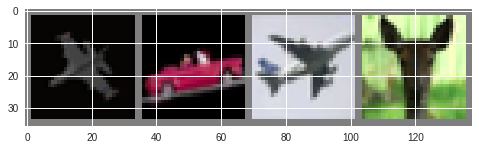

plane   car plane  deer
stride= 1
start training...
[1,  2000] loss: 1.958
[1,  4000] loss: 1.674
[1,  6000] loss: 1.515
[1,  8000] loss: 1.379
[1, 10000] loss: 1.295
[1, 12000] loss: 1.251
[2,  2000] loss: 1.096
[2,  4000] loss: 1.071
[2,  6000] loss: 1.052
[2,  8000] loss: 0.995
[2, 10000] loss: 0.959
[2, 12000] loss: 0.948
Finished Training


In [17]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # mini-batches of 3-channel RGB images of shape (3 x H x W)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = resnet_mine(num_classes = 10)
# transfer to gpu
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('start training...')
for epoch in range(2):
# for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    # 50000，有点大, test也有10000
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # transfer to gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
#         if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
#             cal_accuracy(trainloader)
#             cal_accuracy(testloader)
            running_loss = 0.0

print('Finished Training')

In [5]:
# 这个是针对每个class的accuracy，可以先不跑
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 77 %
Accuracy of  bird : 57 %
Accuracy of   cat : 21 %
Accuracy of  deer : 43 %
Accuracy of   dog : 65 %
Accuracy of  frog : 84 %
Accuracy of horse : 78 %
Accuracy of  ship : 83 %
Accuracy of truck : 85 %


In [18]:
cal_accuracy(testloader)

Accuracy of the network on the images: 66 %


(64, 7, 7, 3)


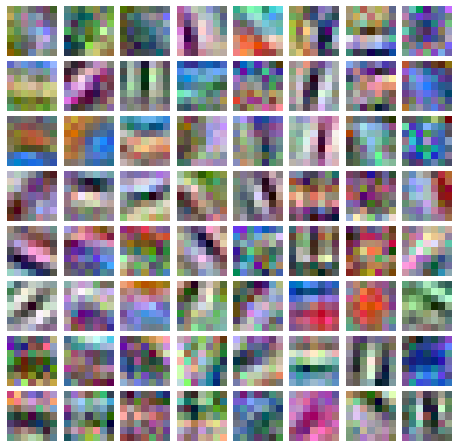

In [12]:
import torch
import torchvision.models as models
from matplotlib import pyplot as plt

def plot_kernels(tensor, num_cols=8):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        tensor[i] = tensor[i] - tensor[i].min()
        tensor[i] = tensor[i] / tensor[i].max()
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
mm = net.double().cpu()
filters = mm.modules
body_model = [i for i in mm.children()][0]
tensor = body_model.weight.data.numpy()
tensor = np.transpose(tensor, (0,2,3,1))
print(np.shape(tensor))
plot_kernels(tensor)


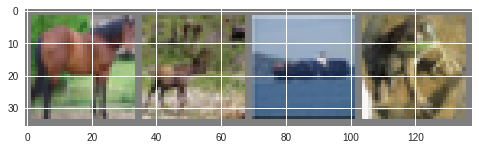

hhh (1, 512, 4, 4)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


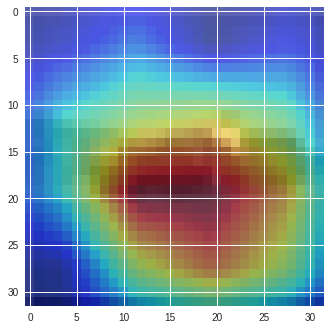

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def getCAM(feature_conv, weight_fc, class_idx):
    print('hhh',np.shape(feature_conv))
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]
  
def get_tsdn(feature_conv):
    print('lll',np.shape(feature_conv))

def unnormalize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


final_layer = net._modules.get('layer4')
fc_activated_features = SaveFeatures(final_layer)

# print('l4',np.shape(activated_features.features[index:index+1]))
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images, labels = images.to(device), labels.to(device)
net = net.to(device).float()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

  
weight_softmax_params = list(net._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
# print(np.shape(weight_softmax))

index = 2
overlay = getCAM(fc_activated_features.features[index:index+1], weight_softmax, predicted[index])
# print('good',np.shape(ap_activated_features.features[index:index+1]))
display_transform = transforms.Compose([transforms.Resize((32,32))])
from PIL import Image
import skimage.transform
from matplotlib.pyplot import imshow
myarray = images[index].cpu()
myarray = unnormalize(myarray)
image = Image.fromarray((myarray*255).astype('uint8'), 'RGB')
imshow(image)
imshow(skimage.transform.resize(overlay[0], (32,32)), alpha=0.5, cmap='jet');

In [24]:
avgpool = net._modules.get('avgpool')
ap_activated_features = SaveFeatures(avgpool)

dataiter = iter(trainloader)
X_out = []
label_out = []
for i in range(25):
    images, labels = dataiter.next()
#     print('aaa',np.shape(images))
    label_out.append(labels.cpu().numpy())
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    X = ap_activated_features.features
    X_out.append(X)

print(np.shape(X_out))
n, bs, nc, h, w = np.shape(X_out)
X_out = np.asarray(X_out)
# reshape might be wrong
X_out = X_out.reshape((n*bs, nc*h*w))
print(np.shape(X_out))
label_out = np.asarray(label_out)
print(np.shape(label_out))
label_out = label_out.reshape((n*bs))
print(np.shape(label_out))

(25, 4, 512, 1, 1)
(100, 512)
(25, 4)
(100,)


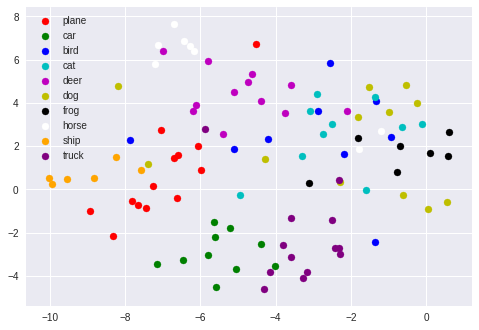

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

X_2d = tsne.fit_transform(X_out)
y = label_out

target_ids = range(10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from matplotlib import pyplot as plt
plt.figure()
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, classes):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [116]:
train_batch_size = 100
test_batch_size = 5
num_workers = 10

activation = []
def hook_feature(module, input, output):
    activation.append(output)


net._modules.get('avgpool').register_forward_hook(hook_feature)

ww torch.Size([5, 3, 32, 32])


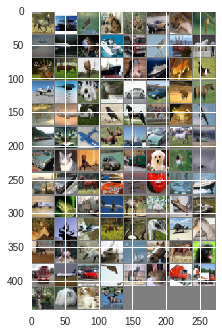

horse  ship  bird   cat  frog   car   dog  bird plane plane  frog  ship truck  bird  ship horse  deer horse  deer  ship   dog  ship   cat  bird plane plane   dog  bird   car   car  deer horse  deer plane   dog  bird horse horse  frog plane  ship   cat plane  deer  ship   car horse  ship   car   cat   dog   car truck   dog  bird plane  ship  ship horse   car plane   car   cat  ship truck  frog truck plane horse   cat   cat plane  deer  deer plane horse  bird  bird plane   cat horse  deer  deer  ship  ship horse horse   dog truck plane   car plane horse  frog truck truck  deer   dog   dog  deer


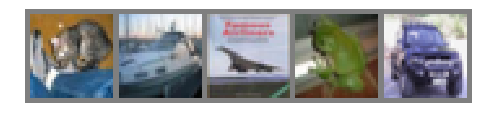

(4,)
(100, 512, 1, 1)
(5, 512, 1, 1)
torch.Size([5, 10])
tensor([[57,  0, 92, 91, 81, 14, 70, 24, 61,  7],
        [79, 37, 49,  9, 93,  7,  2, 83, 96, 87],
        [17, 21, 74, 16, 49, 20, 96,  2, 85, 41],
        [51, 10, 30, 70, 60, 26, 31, 29,  3, 28],
        [79, 93, 15, 68, 87, 22, 73, 39, 38,  2]], device='cuda:0')
tensor(57, device='cuda:0')


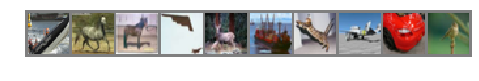

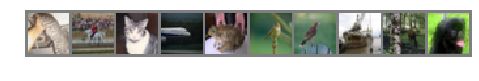

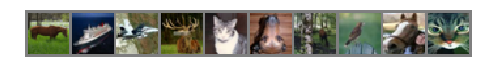

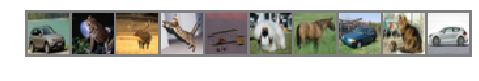

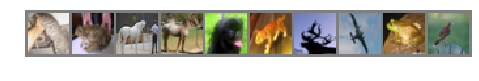

In [118]:
diffidx = [0, 2, 3, 7, 9]
# diffidx = [2]
test_no_same = torch.cat([testset[i][0].view(1, 3, 32, 32) for i in diffidx], 0)

print('ww',np.shape(test_no_same))

knn_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
knn_iter = iter(knn_loader)
knn_images, knn_labels = knn_iter.next()
imshow(torchvision.utils.make_grid(knn_images))
print(' '.join('%5s' % classes[knn_labels[j]] for j in range(train_batch_size)))

plt.axis('off')
imshow(torchvision.utils.make_grid(test_no_same))

knn_images, test_no_same = knn_images.to(device), test_no_same.to(device)

train_outputs = net(knn_images)
test_outputs = net(test_no_same)


feat_train = activation[0].view(1, train_batch_size, 512)
print(np.shape(activation))
print(np.shape(((activation[0].cpu()).data).numpy()))
print(np.shape(((activation[1].cpu()).data).numpy()))
feat_test = activation[1].view(test_batch_size, 1, 512)
# print(np.shape(feat_test))
_, idx = torch.topk(torch.sum((feat_train - feat_test) ** 2, dim=2), 10, dim=1, largest=False)
print(np.shape(idx))
print(idx)
print(idx[0][0])

knn_images = knn_images.detach().cpu()
plt.axis('off')
imshow(torchvision.utils.make_grid(knn_images[idx[0][0:10]], nrow=10))
plt.axis('off')
imshow(torchvision.utils.make_grid(knn_images[idx[1][0:10]], nrow=10))
plt.axis('off')
imshow(torchvision.utils.make_grid(knn_images[idx[2][0:10]], nrow=10))
plt.axis('off')
imshow(torchvision.utils.make_grid(knn_images[idx[3][0:10]], nrow=10))
plt.axis('off')
imshow(torchvision.utils.make_grid(knn_images[idx[4][0:10]], nrow=10))